In [323]:
#Import our dependencies -- make sure to install XGBoost via 'pip install xgboost' command in Bash
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [325]:
#Read in CSV, use Pandas to create dataframe
complete_df = pd.read_csv('Resources/complete_data.csv')

#Converting the 'Date' column to datetime format using pandas
complete_df['Date'] = pd.to_datetime(complete_df['Date'], errors='coerce')

#Display df
complete_df.head()


,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_Year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.00%,-0.00048,30,state,23,f,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.00%,-0.00048,30,state,10,f,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000636,-0.000240,3.915,True,True,True
2,2012-01-01,59.9,0.00%,-0.00048,30,state,42,f,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.00%,-0.00048,30,state,47,f,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000528,0.000734,3.915,True,True,True
4,2012-01-01,59.9,0.00%,-0.00048,30,state,12,f,New Jersey,New Jersey,...,0.000549,0.000502,0.0,0.007897,0.001832,0.006060,3.915,False,False,True


In [326]:
#use get_dummies to convert the categorical columns to [0] and [1] using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 
                                                   'region', 'state', 'property_type'], drop_first=True)
#display df
complete_df.head()

,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,table_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
0,2012-01-01,59.9,0.00%,-0.00048,30,23,87200,-0.383786,-0.514683,130000.0,...,False,False,False,False,False,False,False,False,False,True
1,2012-01-01,59.9,0.00%,-0.00048,30,10,184000,-0.017398,-0.028686,199300.0,...,False,False,False,False,False,False,False,False,False,False
2,2012-01-01,59.9,0.00%,-0.00048,30,42,40000,-0.813084,-0.806061,153700.0,...,False,True,False,False,False,False,False,True,False,False
3,2012-01-01,59.9,0.00%,-0.00048,30,47,79900,-0.092456,-0.007598,94900.0,...,False,False,False,False,False,False,False,False,False,False
4,2012-01-01,59.9,0.00%,-0.00048,30,12,247000,-0.041327,-0.051150,283700.0,...,False,False,False,False,False,False,False,False,False,False


In [329]:
#convert % strings to float values
complete_df['Redfin HPI MoM'] = complete_df['Redfin HPI MoM'].str.rstrip('%').astype(float) / 100


In [331]:
#only numerical columns included in the dataframe now
numeric_df = complete_df.select_dtypes(include=[np.number])
constant_columns = [col for col in numeric_df.columns if numeric_df[col].nunique() == 1]

print(f"Columns with constant values: {constant_columns}")

Columns with constant values: ['period_duration']


In [333]:
complete_df.head()

,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,table_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
0,2012-01-01,59.9,0.0,-0.00048,30,23,87200,-0.383786,-0.514683,130000.0,...,False,False,False,False,False,False,False,False,False,True
1,2012-01-01,59.9,0.0,-0.00048,30,10,184000,-0.017398,-0.028686,199300.0,...,False,False,False,False,False,False,False,False,False,False
2,2012-01-01,59.9,0.0,-0.00048,30,42,40000,-0.813084,-0.806061,153700.0,...,False,True,False,False,False,False,False,True,False,False
3,2012-01-01,59.9,0.0,-0.00048,30,47,79900,-0.092456,-0.007598,94900.0,...,False,False,False,False,False,False,False,False,False,False
4,2012-01-01,59.9,0.0,-0.00048,30,12,247000,-0.041327,-0.051150,283700.0,...,False,False,False,False,False,False,False,False,False,False


In [335]:
#All missing values are filled with mean values
complete_df = complete_df.fillna(complete_df.mean())

In [337]:
#splitting dataset into testing (03/01/2023-09/30/2024) and training (01/01/2014-02/28/2023)
train_data = complete_df[(complete_df['Date'] >= '2014-01-01') & (complete_df['Date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['Date'] >= '2023-03-01') & (complete_df['Date'] <= '2024-09-30')]

In [339]:
#verify the split datasets and display length of rows
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 27407 rows
Testing data: 4760 rows


In [341]:
#drop the insignificant/redundant columns
columns_to_drop = ['Date', 'Case Shiller Index MoM', 'period_duration', 'table_id']  

In [343]:
#defining train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [345]:
#defining (y) target valiable
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

In [347]:
# defining (X) features by removing target column
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

In [349]:
#verify that X_train and X_test, and y_train and y_test, have the same number of rows
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (27407, 151), y_train shape: (27407,)
X_test shape: (4760, 151), y_test shape: (4760,)


In [351]:
#verify test and train have the same set of features (X)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

X_train.head()

,Index SA,Redfin HPI MoM,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,median_list_price_yoy,median_ppsf,median_ppsf_mom,median_ppsf_yoy,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
463,70.2,0.0055,-0.037800,0.110405,190800.0,0.134566,0.102945,95.0,-0.035293,0.102496,...,False,False,False,False,False,False,False,False,True,False
464,70.2,0.0055,0.131444,0.188754,212500.0,0.015022,0.090986,93.0,0.020217,0.092158,...,False,False,False,False,False,False,False,False,False,True
465,70.2,0.0055,-0.049406,-0.047143,126100.0,0.464968,0.073709,60.0,-0.128450,-0.046997,...,False,False,False,False,False,False,False,False,False,True
466,70.2,0.0055,-0.038744,0.231477,412100.0,0.086573,0.157841,248.0,-0.027588,0.249806,...,False,False,False,False,False,False,False,False,False,False
467,70.2,0.0055,-0.109733,0.025714,190000.0,0.188243,0.188243,85.0,-0.167753,0.013070,...,False,False,False,False,False,False,False,False,False,True


In [353]:
#initialize the model - XGBOOST
xg_reg = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [355]:
#fitting XGBoost model
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [356]:
#predict test data using xgboost model
y_pred = xg_reg.predict(X_test)

In [357]:
#Model Evaluation, defining MSE, MAE, and r^2
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

In [358]:
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 4752483135.748715
Mean Absolute Error: 31085.416844472165
R² Score: 0.8782984667958691


In [359]:
#extracting the feature importances from trained model
importances = xg_reg.feature_importances_

In [363]:
#get the names of columns in X_train, our features
feature_names = X_train.columns

In [366]:
#sorting the features in descending order by Feature Importantce
sorted_indices = importances.argsort()[::-1]
top_n = 25  # Number of top features to select
top_features = feature_names[sorted_indices][:top_n]
top_importances = importances[sorted_indices][:top_n]

Text(0, 0.5, 'Features')

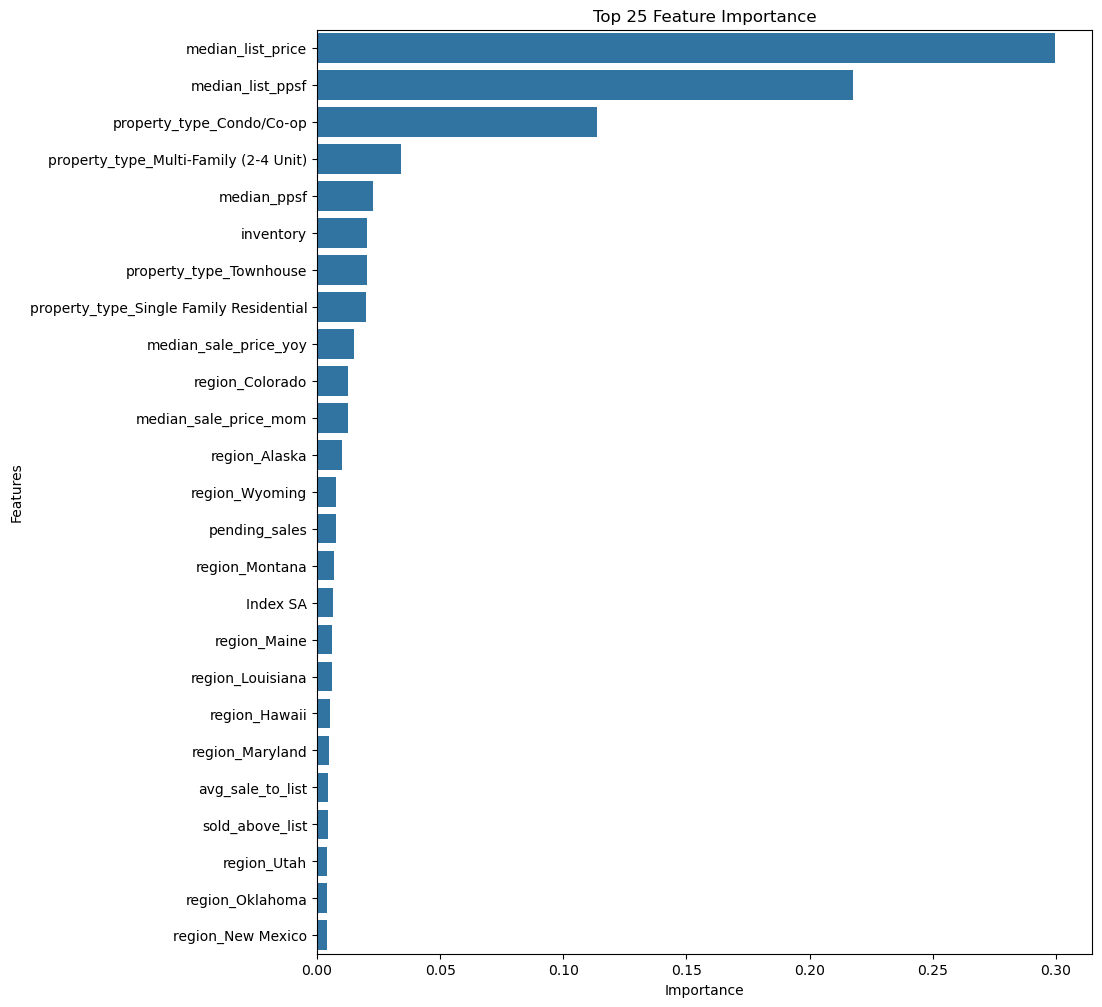

In [369]:
#PLot of feature importance, top 25
plt.figure(figsize=(10, 12))
sns.barplot(y=top_features, x=top_importances, orient="h")
plt.title("Top 25 Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

In [370]:
plt.savefig('Resources/top_25_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [371]:
#create a dataset filter to include only the top 25 features 
X_train_top25 = X_train[top_features]
X_test_top25 = X_test[top_features]

In [375]:
#Now that the parameters have been updated, reinitialize the model with new parameters
xg_reg_top25 = xgb.XGBRegressor(n_estimators=75, random_state=42, n_jobs=-1)

In [377]:
#Fitting model with only the top 25 features
xg_reg_top25.fit(X_train_top25, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=75,
             n_jobs=-1, num_parallel_tree=None, ...)

In [379]:
#predict using the new, updated model with only top 25 features
y_pred_top25 = xg_reg_top25.predict(X_test_top25)

In [381]:
#Defining MSE, MAE, and r^2 of top 25 features. 
mse_top25 = mean_squared_error(y_test, y_pred_top25)

mae_top25 = mean_absolute_error(y_test, y_pred_top25)

r2_top25 = r2_score(y_test, y_pred_top25)

In [383]:
#Print results
print(f"Mean Squared Error: {mse_top25}")
print(f"Mean Absolute Error: {mae_top25}")
print(f"R² Score: {r2_top25}")

Mean Squared Error: 4585923987.759369
Mean Absolute Error: 33659.201000361085
R² Score: 0.8825637115322471


In [385]:
#initialize XGBoost, replacing the amount of estimators n_estimators to 100
xg_reg_top25 = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)


In [387]:
#Train the model on y_train and X_train_top25

xg_reg_top25.fit(X_train_top25, y_train)


#Generate predictions from updated model

y_pred_top25 = xg_reg_top25.predict(X_test_top25)  # Ensure you're using Top 25 features

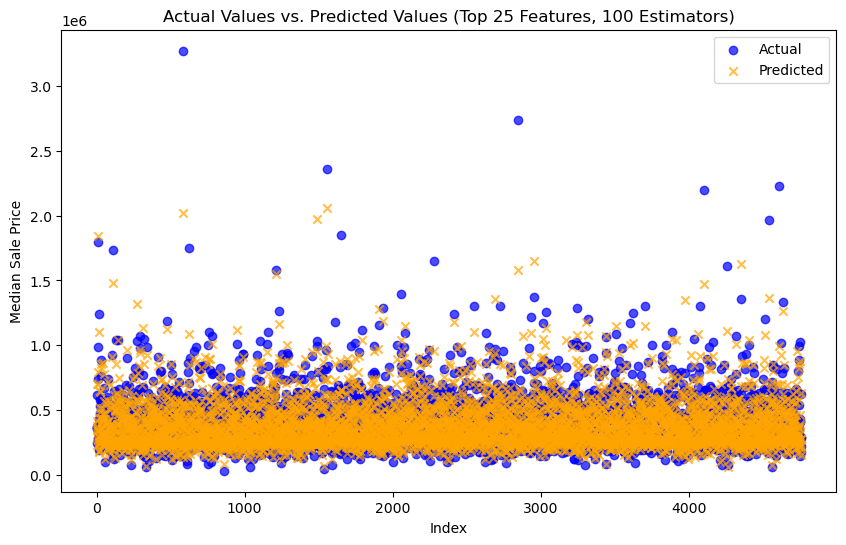

In [389]:
#Scatterplot: Actual vs Predicted Results of model

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.7)
plt.scatter(range(len(y_pred_top25)), y_pred_top25, label="Predicted", color="orange", alpha=0.7, marker='x')
plt.xlabel("Index")
plt.ylabel("Median Sale Price")
plt.title("Actual Values vs. Predicted Values (Top 25 Features, 100 Estimators)")
plt.legend()
plt.show()

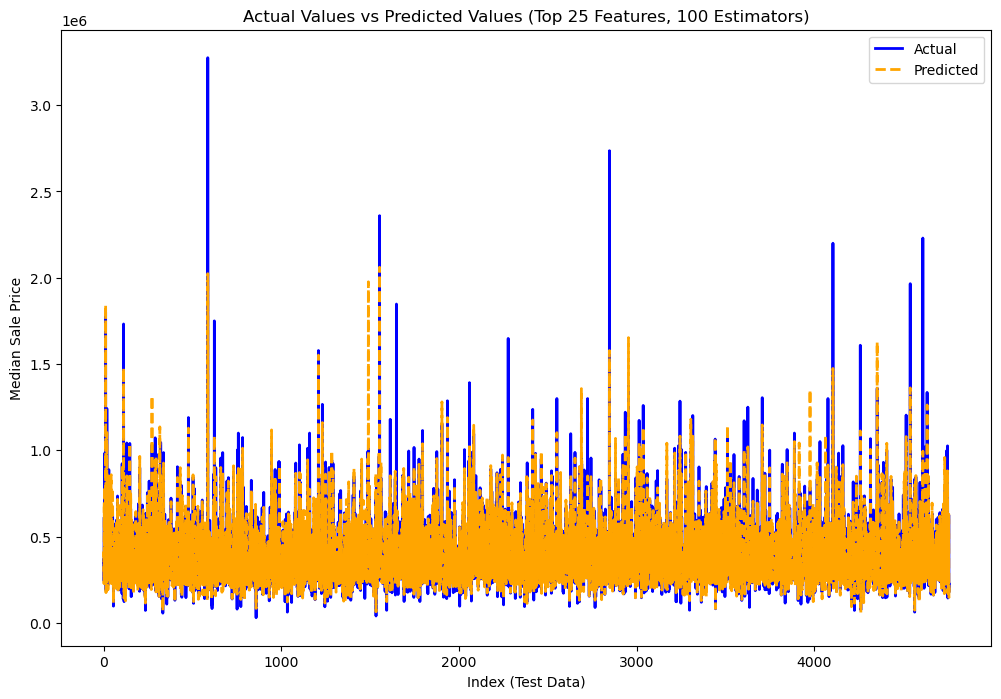

In [391]:
#Line Graph for actual vs predicted results of model
# Use the range for the x-axis (indices of the test data)

plt.figure(figsize=(12, 8))


# Sequential index from 0 to the length of y_test

x = np.arange(len(y_test))

plt.plot(x, y_test.values, label='Actual', color='blue', linewidth=2)  
plt.plot(x, y_pred_top25, label='Predicted', color='orange', linewidth=2, linestyle='--') 
plt.xlabel('Index (Test Data)')
plt.ylabel('Median Sale Price')
plt.title('Actual Values vs Predicted Values (Top 25 Features, 100 Estimators)')
plt.legend()
plt.show()

In [393]:
#residuals for best model
residuals = y_test - y_pred_top25

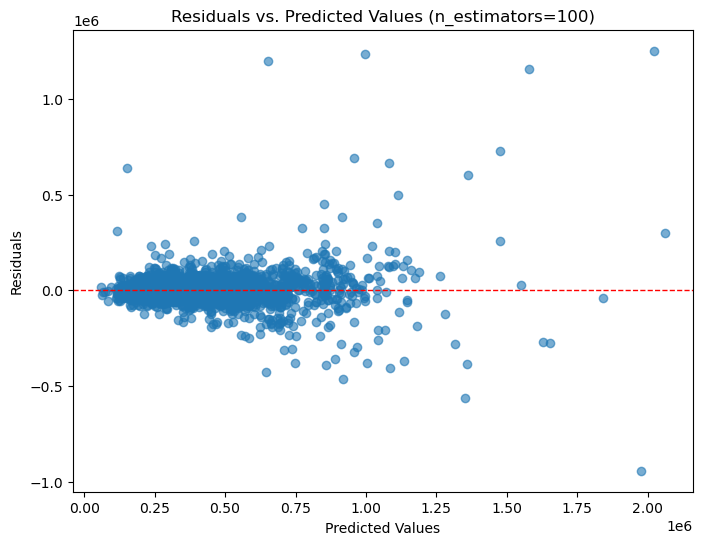

In [395]:
#Scatterplot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_top25, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals vs. Predicted Values (n_estimators=100)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [397]:
#round up values to the nearest hundredths place
actual_values = np.round(y_test.values, 2)  
predicted_values = np.round(y_pred_top25, 2)  
differences = np.round(actual_values - predicted_values, 2)

In [399]:
#store and print results dataframe
results = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Difference': differences
})

#show the results
print(results)

      Actual      Predicted  Difference
0     353000  413571.968750   -60571.97
1     371400  343990.125000    27409.88
2     243700  227148.578125    16551.42
3     612500  698574.187500   -86074.19
4     358700  356425.250000     2274.75
...      ...            ...         ...
4755  281000  278186.312500     2813.69
4756  290400  276489.968750    13910.03
4757  625100  630392.437500    -5292.44
4758  177200  147857.296875    29342.70
4759  224600  219763.000000     4837.00

[4760 rows x 3 columns]


In [401]:
#Save and create a CSV file as xgboost_results.csv
results.to_csv('Resources/xgboost_results.csv', index=False)

In [403]:
print("Results saved with Actual, Predicted and Difference columns!")

Results saved with Actual, Predicted and Difference columns!
